# Team Name : Hadoop Heros 


### Importing libraries and creating spark context 

In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [2]:
 #datawarehouse_location points to the default location for managed databases and tables
from os.path import abspath
warehouse_location = abspath('spark-warehouse')

spark = sparkSession = (SparkSession
                .builder
                .master("local[*]") 
                .appName("Bank Marketing big data project") 
                .config("hive.metastore.uris", "thrift://localhost:9083", conf=SparkConf())
                .enableHiveSupport()
                .getOrCreate()
                )
# note: If you have multiple spark sessions running (like from a previous notebook you've run), 
# this spark session webUI will be on a different port than the default (4040). One way to 
# identify this part is with the following line. If there was only one spark session running, 
# this will be 4040. If it's higher, it means there are still other spark sesssions still running.
spark_session_port = spark.sparkContext.uiWebUrl.split(":")[-1]
print("Spark Session WebUI Port: " + spark_session_port)

23/11/10 06:34:26 WARN Utils: Your hostname, localhost.localdomain resolves to a loopback address: 127.0.0.1; using 10.21.12.68 instead (on interface eth0)
23/11/10 06:34:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/10 06:34:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session WebUI Port: 4040


In [3]:
spark 

### Import pandas dataframe and load the dataset ie csv file 

In [4]:
import pandas as pd 

In [5]:
df = pd.read_csv('data/yellow_tripdata_2022-02.csv')

df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,extra,tip_amount,total_amount,airport_fee
0,1,2/1/2022 0:06,2/1/2022 0:19,1,5.40,138,252,17.0,1.75,3.90,23.45,1.25
1,1,2/1/2022 0:38,2/1/2022 0:55,1,6.40,138,41,21.0,1.75,0.00,30.10,1.25
2,1,2/1/2022 0:03,2/1/2022 0:26,1,12.50,138,200,35.5,1.75,0.00,44.60,1.25
3,2,2/1/2022 0:08,2/1/2022 0:28,1,9.88,239,200,28.0,0.50,0.00,34.80,0.00
4,2,2/1/2022 0:06,2/1/2022 0:33,1,12.16,138,125,35.5,0.50,8.11,48.66,1.25


### load data to spark dataframe 

In [6]:
trips = spark.read.csv('data/yellow_tripdata_2022-02.csv' , header = True , inferSchema=True)

# display the first 10 rows of the dataframe 

trips.show(10)


+--------+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+----------+------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|fare_amount|extra|tip_amount|total_amount|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+----------+------------+-----------+
|       1|       2/1/2022 0:06|        2/1/2022 0:19|              1|          5.4|         138|         252|       17.0| 1.75|       3.9|       23.45|       1.25|
|       1|       2/1/2022 0:38|        2/1/2022 0:55|              1|          6.4|         138|          41|       21.0| 1.75|       0.0|        30.1|       1.25|
|       1|       2/1/2022 0:03|        2/1/2022 0:26|              1|         12.5|         138|         200|       35.5| 1.75|       0.0|        44.6|       1.25|
|       2|      

In [7]:
trips.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- airport_fee: double (nullable = true)



### Data-preprocessing and Exploration using SQL 

In [8]:
### create db and table in spark 

trips.createOrReplaceTempView("trips_tmp_view")


In [9]:
df= spark.sql("SELECT * FROM trips_tmp_view")

df.show(10)

+--------+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+----------+------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|fare_amount|extra|tip_amount|total_amount|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+----------+------------+-----------+
|       1|       2/1/2022 0:06|        2/1/2022 0:19|              1|          5.4|         138|         252|       17.0| 1.75|       3.9|       23.45|       1.25|
|       1|       2/1/2022 0:38|        2/1/2022 0:55|              1|          6.4|         138|          41|       21.0| 1.75|       0.0|        30.1|       1.25|
|       1|       2/1/2022 0:03|        2/1/2022 0:26|              1|         12.5|         138|         200|       35.5| 1.75|       0.0|        44.6|       1.25|
|       2|      

In [10]:
type(trips)

pyspark.sql.dataframe.DataFrame

In [11]:
spark.sql("CREATE DATABASE IF NOT EXISTS trips_db;")

23/11/10 06:34:38 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/10 06:34:38 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/11/10 06:34:41 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/11/10 06:34:41 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore student@127.0.0.1


DataFrame[]

In [12]:
trips.write.mode("overwrite").saveAsTable("trips_db.trips")

23/11/10 06:34:41 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/11/10 06:34:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/11/10 06:34:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
23/11/10 06:34:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
23/11/10 06:34:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
23/11/10 06:34:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
23/11/10 06:34:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row

In [13]:
spark.catalog.listTables('trips_db')

[Table(name='trips', catalog='spark_catalog', namespace=['trips_db'], description=None, tableType='MANAGED', isTemporary=False),
 Table(name='trips_tmp_view', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

In [14]:
df = spark.sql("SELECT * FROM trips_db.trips")
df.show(10)

+--------+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+----------+------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|fare_amount|extra|tip_amount|total_amount|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+----------+------------+-----------+
|       2|      2/6/2022 18:00|       2/6/2022 18:15|              1|         3.09|         230|         263|       12.5|  0.0|      3.16|       18.96|        0.0|
|       1|      2/6/2022 18:05|       2/6/2022 18:54|              1|         19.5|         132|          26|       56.0| 1.25|       0.0|       58.05|       1.25|
|       1|      2/6/2022 18:33|       2/6/2022 18:52|              1|          4.3|         231|         142|       16.0|  2.5|       1.0|        20.3|        0.0|
|       1|      

In [15]:
df = spark.sql(" describe trips_db.trips")
df.show()

+--------------------+---------+-------+
|            col_name|data_type|comment|
+--------------------+---------+-------+
|            VendorID|      int|   NULL|
|tpep_pickup_datetime|   string|   NULL|
|tpep_dropoff_date...|   string|   NULL|
|     passenger_count|      int|   NULL|
|       trip_distance|   double|   NULL|
|        PULocationID|      int|   NULL|
|        DOLocationID|      int|   NULL|
|         fare_amount|   double|   NULL|
|               extra|   double|   NULL|
|          tip_amount|   double|   NULL|
|        total_amount|   double|   NULL|
|         airport_fee|   double|   NULL|
+--------------------+---------+-------+



### Number of Trips by VendorID 

In [16]:
vendor1_trips = spark.sql("""SELECT COUNT(VendorID) as vendorID1 
    FROM trips_db.trips 
    WHERE VendorID=1""")

vendor1_trips.show()

+---------+
|vendorID1|
+---------+
|   319007|
+---------+



In [17]:
vendor2_trips = spark.sql("""SELECT COUNT(VendorID) as vendorID2 
    FROM trips_db.trips 
    WHERE VendorID=2""")

vendor2_trips.show()

+---------+
|vendorID2|
+---------+
|   724579|
+---------+



In [18]:
!pip install matplotlib


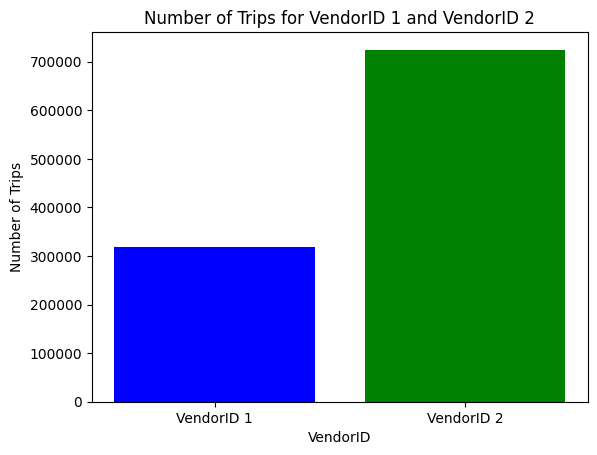

In [19]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

# Convert the result to Pandas for easy plotting
vendor1_count = vendor1_trips.toPandas()['vendorID1'][0]
vendor2_count = vendor2_trips.toPandas()['vendorID2'][0]

# Plotting the bar chart
vendors = ['VendorID 1', 'VendorID 2']
counts = [vendor1_count, vendor2_count]

plt.bar(vendors, counts, color=['blue', 'green'])
plt.title('Number of Trips for VendorID 1 and VendorID 2')
plt.xlabel('VendorID')
plt.ylabel('Number of Trips')
plt.show()


### Number of trips by pickup and dropff location 

In [20]:

# count of each pickup location 

pickup_trips = spark.sql("""SELECT PULocationID, COUNT(*) AS pickup_count 
    FROM trips_db.trips 
    GROUP BY PULocationID
    ORDER BY pickup_count DESC""")

pickup_trips.show()



+------------+------------+
|PULocationID|pickup_count|
+------------+------------+
|         237|       55209|
|         236|       52974|
|         161|       41126|
|         162|       35420|
|         142|       34384|
|         186|       34369|
|         170|       33203|
|         132|       32341|
|         239|       32263|
|          48|       31510|
|         141|       30099|
|         230|       29825|
|         163|       29167|
|         234|       28463|
|          79|       26295|
|         238|       26257|
|          68|       26134|
|         107|       26053|
|         140|       25555|
|         263|       24865|
+------------+------------+
only showing top 20 rows



In [21]:

# count of each dropoff location 

dropoff_trips = spark.sql("""SELECT DOLocationID, COUNT(*) AS dropoff_count 
    FROM trips_db.trips
    GROUP BY DOLocationID 
    ORDER BY dropoff_count DESC""")

dropoff_trips.show()

+------------+-------------+
|DOLocationID|dropoff_count|
+------------+-------------+
|         236|        54140|
|         237|        48257|
|         161|        34393|
|         239|        32257|
|         170|        32028|
|         141|        31752|
|         142|        29920|
|         238|        28305|
|          48|        27783|
|         162|        26909|
|         230|        25045|
|         234|        24873|
|         163|        24807|
|         263|        24779|
|         140|        24667|
|          68|        24638|
|         229|        23356|
|          79|        22013|
|         107|        22002|
|         186|        21423|
+------------+-------------+
only showing top 20 rows



### The most frequented pick up and drop off location are  Taxi Zones 237 & 236

### Which vendor provides a better service? Assumption : Tipping being a metric for good service 

In [22]:
avg_tip_per_vendor = spark.sql("""SELECT VendorID, ROUND(AVG(tip_amount),2) AS avg_tip 
    FROM trips_db.trips 
    GROUP BY VendorID 
    ORDER BY avg_tip DESC """)

avg_tip_per_vendor.show()


+--------+-------+
|VendorID|avg_tip|
+--------+-------+
|       2|   2.48|
|       1|   2.33|
+--------+-------+



### THe avg_tip difference between both vendors is very small and from above it is known vendor 2 has almost twice the number of trips than the vendor 1 
### it might be challening to draw a conclusion on service quality 

### What is the average fare amount  for the trips with rush hour or overnight charge? 

In [23]:
avg_fare_amount_rush_hour = spark.sql("""SELECT ROUND(AVG(fare_amount),3) as avg_fare_amount 
    FROM trips_db.trips 
    WHERE extra > 0""")

avg_fare_amount_rush_hour.show()


+---------------+
|avg_fare_amount|
+---------------+
|         12.133|
+---------------+



### What is the average total amount collected for trips with more than 2 passengers ? 

In [24]:
avg_total_for_large_groups = spark.sql("""SELECT ROUND(AVG(total_amount),2) as total_fare 
    FROM trips_db.trips  
    WHERE passenger_count > 2""")

avg_total_for_large_groups.show()


+----------+
|total_fare|
+----------+
|     19.23|
+----------+



### What is the avergare trip distance for each passenger count? 

In [25]:
avg_distance_per_passenger = spark.sql("""SELECT passenger_count, ROUND(AVG(trip_distance),2) as avg_distance 
    FROM trips_db.trips 
    GROUP BY passenger_count""")

avg_distance_per_passenger.show() 


+---------------+------------+
|passenger_count|avg_distance|
+---------------+------------+
|              1|        2.84|
|              6|        2.92|
|              3|        3.02|
|              5|         2.9|
|              4|         3.1|
|              2|        3.23|
|              0|        2.61|
|              8|        1.66|
|              9|         0.0|
|              7|        0.73|
+---------------+------------+



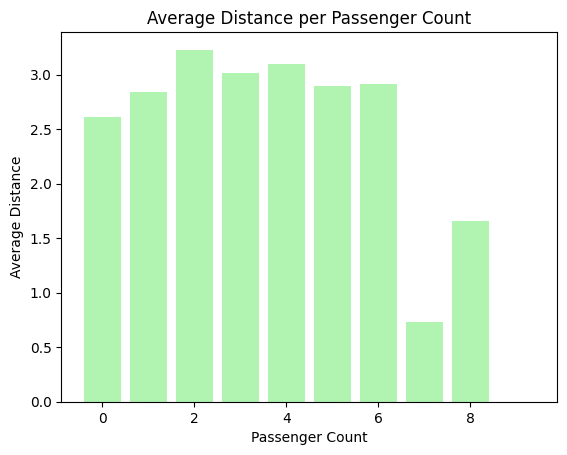

In [26]:


# Convert Spark DataFrame to Pandas DataFrame
avg_distance_per_passenger_pd = avg_distance_per_passenger.toPandas()

# Plotting the histogram using Pandas DataFrame
plt.bar(avg_distance_per_passenger_pd['passenger_count'], avg_distance_per_passenger_pd['avg_distance'], color='lightgreen', alpha=0.7)
plt.xlabel('Passenger Count')
plt.ylabel('Average Distance')
plt.title('Average Distance per Passenger Count')
plt.show() 


#### What is the relation between trip distance and fare amount ? 

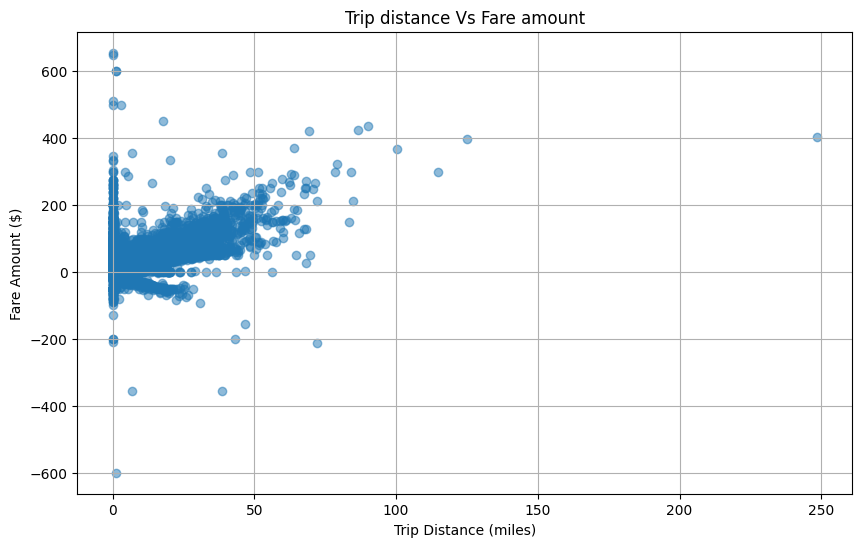

In [27]:

trips_pd = trips.toPandas()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(trips_pd['trip_distance'], trips_pd['fare_amount'], alpha=0.5)
plt.title('Trip distance Vs Fare amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.grid(True)
plt.show()

### From the above scatter , general trend seems to increase in fare amount for every additional mile travelled . Negative fares might represent refund amount for cancelled trips.
### Zero fare amount for distance travelled may represnt promotional offers for the ride. Fare amounts for zero distance travelled might be cancellation of trips after late cancellation 
### or minimum fare charged regardless of distance travelled. 

### understanding structure of data and proceed with datacleaning if any required 

In [28]:
# Retreving column names 

trips.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'PULocationID',
 'DOLocationID',
 'fare_amount',
 'extra',
 'tip_amount',
 'total_amount',
 'airport_fee']

In [29]:
# number of rows
num_rows = trips.count()

#  number of columns
num_columns = len(trips.columns)

print("Number of rows: {}".format(num_rows))
print("Number of columns: {}".format(num_columns))


Number of rows: 1043586
Number of columns: 12


In [30]:
trips.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- airport_fee: double (nullable = true)



In [31]:
selected_columns = ['VendorID', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'fare_amount', 'extra', 'airport_fee']

In [32]:
selected_data = trips.select(selected_columns)

In [33]:
# Drop rowns with any null values 
selected_data = selected_data.dropna() 


In [34]:
from pyspark.ml.feature import VectorAssembler

feature_cols = ['VendorID', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'extra', 'airport_fee']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
selected_data = assembler.transform(selected_data)


In [35]:
# Split the data into training and testing sets and setting seed for reproducability 
(train_data, test_data) = selected_data.randomSplit([0.8, 0.2], seed=12345)

## Linear Regression 

In [39]:
from pyspark.ml.regression import LinearRegression


In [ ]:
# using regularization to avoid overfitting 

In [41]:
# linear regression model
lr = LinearRegression(featuresCol="features", labelCol="fare_amount" , regParam=0.01)

lr_model_fit = lr.fit(train_data) 




In [43]:
# make predictions on test test set 

predictions = lr_model.transform(test_data)

predictions.show()

+--------+---------------+-------------+------------+------------+-----------+-----+-----------+--------------------+------------------+
|VendorID|passenger_count|trip_distance|PULocationID|DOLocationID|fare_amount|extra|airport_fee|            features|        prediction|
+--------+---------------+-------------+------------+------------+-----------+-----+-----------+--------------------+------------------+
|       1|              0|          0.0|         145|         145|        2.5|  0.0|        0.0|(7,[0,3,4],[1.0,1...| 7.436901487989827|
|       1|              0|          0.1|         162|         161|        3.5|  2.5|        0.0|[1.0,0.0,0.1,162....| 5.599024316955831|
|       1|              0|          0.1|         239|         239|        3.0|  2.5|        0.0|[1.0,0.0,0.1,239....| 5.609854930942885|
|       1|              0|          0.2|         161|         230|        3.5|  2.5|        0.0|[1.0,0.0,0.2,161....|  5.85933320748763|
|       1|              0|          0.3| 

### Model Evaluation

In [45]:
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 5.568032314321241


## Decision Tree 

In [52]:
from pyspark.ml.regression import  DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [53]:
# Decisison tree model 
dt = DecisionTreeRegressor(labelCol='fare_amount', featuresCol='features')


In [54]:
# create a pipeline 

pipe = Pipeline(stages=[dt])

In [57]:
#Train the model 

dt_model = pipe.fit(train_data)


In [58]:
# make predictions on test data 

dt_predictions = dt_model.transform(test_data)

In [59]:
dt_evaluator = MulticlassClassificationEvaluator(
    labelCol='fare_amount', predictionCol="prediction", metricName="accuracy")

accuracy = dt_evaluator.evaluate(dt_predictions)

print(f"The accuracy of the decision tree classifier is {accuracy}")

The accuracy of the decision tree classifier is 0.0
